In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt




In [36]:
horse_data = pd.read_csv("data/horse.csv")
training_data = pd.read_csv("data/train.csv")

In [37]:

horse_data = pd.concat([horse_data, training_data], axis=0, ignore_index=True)


In [38]:
horse_data.columns

Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'outcome', 'surgical_lesion', 'lesion_1', 'lesion_2',
       'lesion_3', 'cp_data', 'id'],
      dtype='object')

In [39]:
#drop columns of little to no signifigance (based on previous running of the model)
horse_data.drop(columns=["hospital_number",'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data'], inplace=True)


In [40]:
horse_data.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,id
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,...,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,NaN
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,...,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,NaN
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,...,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,NaN
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,...,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,NaN
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,...,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,NaN


In [41]:
#euthenized means died so reduce the number of outcomes from 3 to 2
horse_data["outcome"].replace("euthanized", "died", inplace=True)

In [42]:
# Reorder the columns
column_order = ['id'] + [col for col in horse_data.columns if col != 'id']
horse_data = horse_data[column_order]

horse_data.head()

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion
0,NaN,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no
1,NaN,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,died,no
2,NaN,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no
3,NaN,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes
4,NaN,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no


In [43]:
horse_data['id'] = horse_data['id'].fillna(0)


In [45]:
#check for null values
print(horse_data.columns[horse_data.isnull().any()])

Index(['rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities',
       'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain',
       'peristalsis', 'abdominal_distention', 'nasogastric_tube',
       'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces',
       'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein'],
      dtype='object')


In [46]:
#fill any na values in numerical columns with the median value of the column 
numerical_features = horse_data.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    horse_data[feature].fillna(horse_data[feature].median(), inplace=True)

#fill any na values in categorical column with none
categorical_features = horse_data.select_dtypes(include=[np.object]).columns.tolist()
for feature in categorical_features:
    horse_data[feature].fillna('None', inplace=True)

C:\Users\sarah\AppData\Local\Temp\ipykernel_19272\1003930315.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = horse_data.select_dtypes(include=[np.object]).columns.tolist()


In [47]:
#check if null values are gone
print(horse_data.columns[horse_data.isnull().any()])

Index([], dtype='object')


In [48]:
# Separate features (X) and target variable (y) for training data
X = horse_data.drop(columns=["outcome"])
y = horse_data["outcome"]

label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(y)

In [49]:
# Check the mapping of classes to encoded values
classes = label_encoder.classes_
encoded_values = label_encoder.transform(classes)

# Print the mapping
for class_name, encoded_value in zip(classes, encoded_values):
    print(f"Class: {class_name} => Encoded Value: {encoded_value}")

Class: died => Encoded Value: 0
Class: lived => Encoded Value: 1


In [50]:
#define categorical columns and split the data
categorical_columns = list(X.loc[:, X.dtypes == 'object'].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size= 0.2, random_state=42)


In [51]:
#read in the model
model = CatBoostClassifier(cat_features=categorical_columns, random_seed = 42, verbose=3)

#param grid for grid search
param_grid = {
    'iterations': [100, 300, 500],            
    'learning_rate': [0.01, 0.1],        
    'depth': [6, 8],                       
}

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3, scoring = 'neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.6899823	total: 60.7ms	remaining: 6.01s
3:	learn: 0.6802565	total: 273ms	remaining: 6.54s
6:	learn: 0.6708455	total: 429ms	remaining: 5.71s
9:	learn: 0.6609897	total: 588ms	remaining: 5.29s
12:	learn: 0.6503492	total: 715ms	remaining: 4.79s
15:	learn: 0.6406672	total: 867ms	remaining: 4.55s
18:	learn: 0.6324429	total: 1.01s	remaining: 4.32s
21:	learn: 0.6247354	total: 1.35s	remaining: 4.79s
24:	learn: 0.6174485	total: 1.6s	remaining: 4.81s
27:	learn: 0.6087441	total: 1.8s	remaining: 4.64s
30:	learn: 0.6026183	total: 1.96s	remaining: 4.35s
33:	learn: 0.5969883	total: 2.08s	remaining: 4.05s
36:	learn: 0.5908346	total: 2.23s	remaining: 3.8s
39:	learn: 0.5851791	total: 2.39s	remaining: 3.58s
42:	learn: 0.5778068	total: 2.58s	remaining: 3.42s
45:	learn: 0.5717988	total: 2.79s	remaining: 3.28s
48:	learn: 0.5662161	total: 2.96s	remaining: 3.08s
51:	learn: 0.5623378	total: 3.09s	remaining: 2.85s
54:	learn: 0.5570506	total:

In [52]:
#define categorical columns 
categorical_columns = list(X_train.loc[:, X_train.dtypes == 'object'].columns)

#read in model
#model = CatBoostClassifier(cat_features=categorical_columns, random_seed = 42, verbose=3)

#best params saved from gridsearch
#best_params = {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

#best model with params
best_model = CatBoostClassifier(cat_features = categorical_columns, random_seed = 42, verbose = 3, **best_params)

#fit the data
best_model.fit(X_train, y_train)

0:	learn: 0.6890777	total: 301ms	remaining: 1m 30s
3:	learn: 0.6781447	total: 873ms	remaining: 1m 4s
6:	learn: 0.6655078	total: 1.64s	remaining: 1m 8s
9:	learn: 0.6537286	total: 2.25s	remaining: 1m 5s
12:	learn: 0.6429969	total: 3.33s	remaining: 1m 13s
15:	learn: 0.6330502	total: 3.93s	remaining: 1m 9s
18:	learn: 0.6240624	total: 4.84s	remaining: 1m 11s
21:	learn: 0.6154418	total: 5.37s	remaining: 1m 7s
24:	learn: 0.6066134	total: 5.93s	remaining: 1m 5s
27:	learn: 0.5965437	total: 6.51s	remaining: 1m 3s
30:	learn: 0.5887440	total: 7.05s	remaining: 1m 1s
33:	learn: 0.5822985	total: 7.51s	remaining: 58.8s
36:	learn: 0.5741368	total: 8.22s	remaining: 58.4s
39:	learn: 0.5676262	total: 8.7s	remaining: 56.5s
42:	learn: 0.5595265	total: 9.31s	remaining: 55.6s
45:	learn: 0.5516870	total: 9.86s	remaining: 54.5s
48:	learn: 0.5440590	total: 10.5s	remaining: 53.6s
51:	learn: 0.5367640	total: 11s	remaining: 52.5s
54:	learn: 0.5305313	total: 11.5s	remaining: 51s
57:	learn: 0.5235700	total: 12s	remai

In [53]:
#use the model to make predictions on X_test
y_pred = best_model.predict(X_test)

print(y_pred)

[0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0
 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0
 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0
 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0
 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 1 0]


In [54]:
# Calculate f-1 score
f1 = f1_score(y_test, y_pred, average='micro')
print("F1 Score:", f1)



F1 Score: 0.752442996742671


In [19]:
#save the model
import joblib

# Save the trained model to a file
joblib.dump(best_model, 'catBoostClassifier_model.pkl')

['catBoostClassifier_model.pkl']

In [20]:
#load in the model 
loaded_model = joblib.load('catBoostClassifier_model.pkl')


In [21]:
#read in test data from kaggle
test_data = pd.read_csv("data/test.csv")


In [22]:

#drop the same columns from the test data 
test_data.drop(columns=["hospital_number",'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data'], inplace=True)


In [23]:
#check columns match
print(test_data.columns)
print(horse_data.columns)

Index(['id', 'surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_appearance', 'abdomo_protein', 'surgical_lesion'],
      dtype='object')
Index(['id', 'surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_appearance', 'abdomo_protein', 'outcome', 'surgical_lesion'],
      dtype='object')


In [24]:
#test model on test_data from kaggle
categorical_columns = list(test_data.loc[:, test_data.dtypes == 'object'].columns)

test_predictions = loaded_model.predict(test_data)

test_predictions


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,

In [26]:
#make dataframe of predictions
submission_df = pd.DataFrame({'id': test_data['id'],
                           'outcome': test_predictions})

submission_df.head()

,id,outcome
0,1235,1
1,1236,0
2,1237,1
3,1238,0
4,1239,1


In [59]:
# undo encoding
submission_df['outcome'] = submission_df['outcome'].replace({1: 'lived',
                                                             0: 'died'})

print(len(submission_df))
submission_df.head()

824


,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,died
4,1239,lived


In [57]:
# make csv files of my X_train, X_test, and submission file
X_train.to_csv("data/X_train.csv", index=False)
X_test.to_csv("data/X_test.csv", index=False)
submission_df.to_csv("data/submission.csv", index=False)


Text(0.5, 1.0, 'Feature Importance')

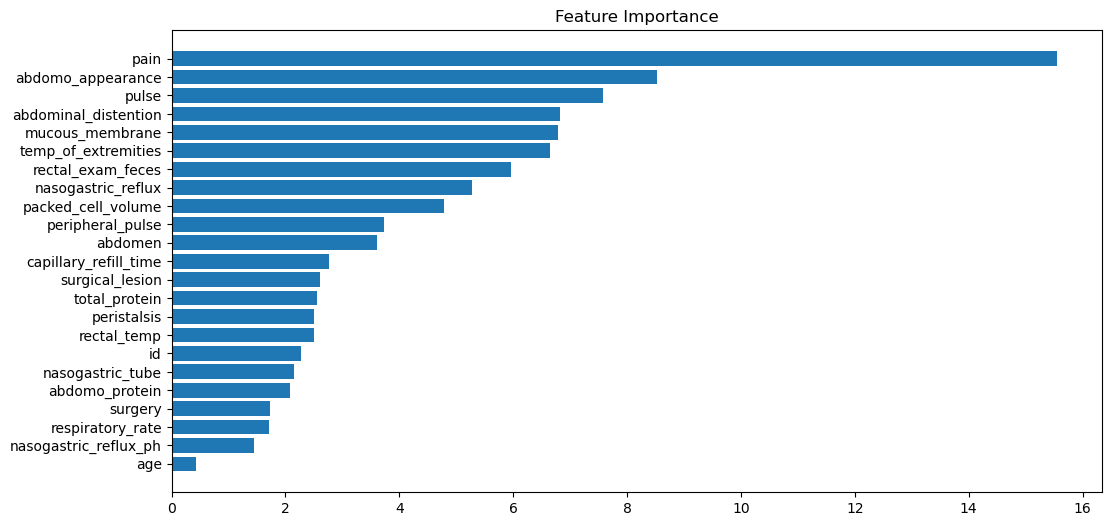

In [55]:
import matplotlib.pyplot as plt

feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
# Use the column names from X_train as feature labels
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.title('Feature Importance')


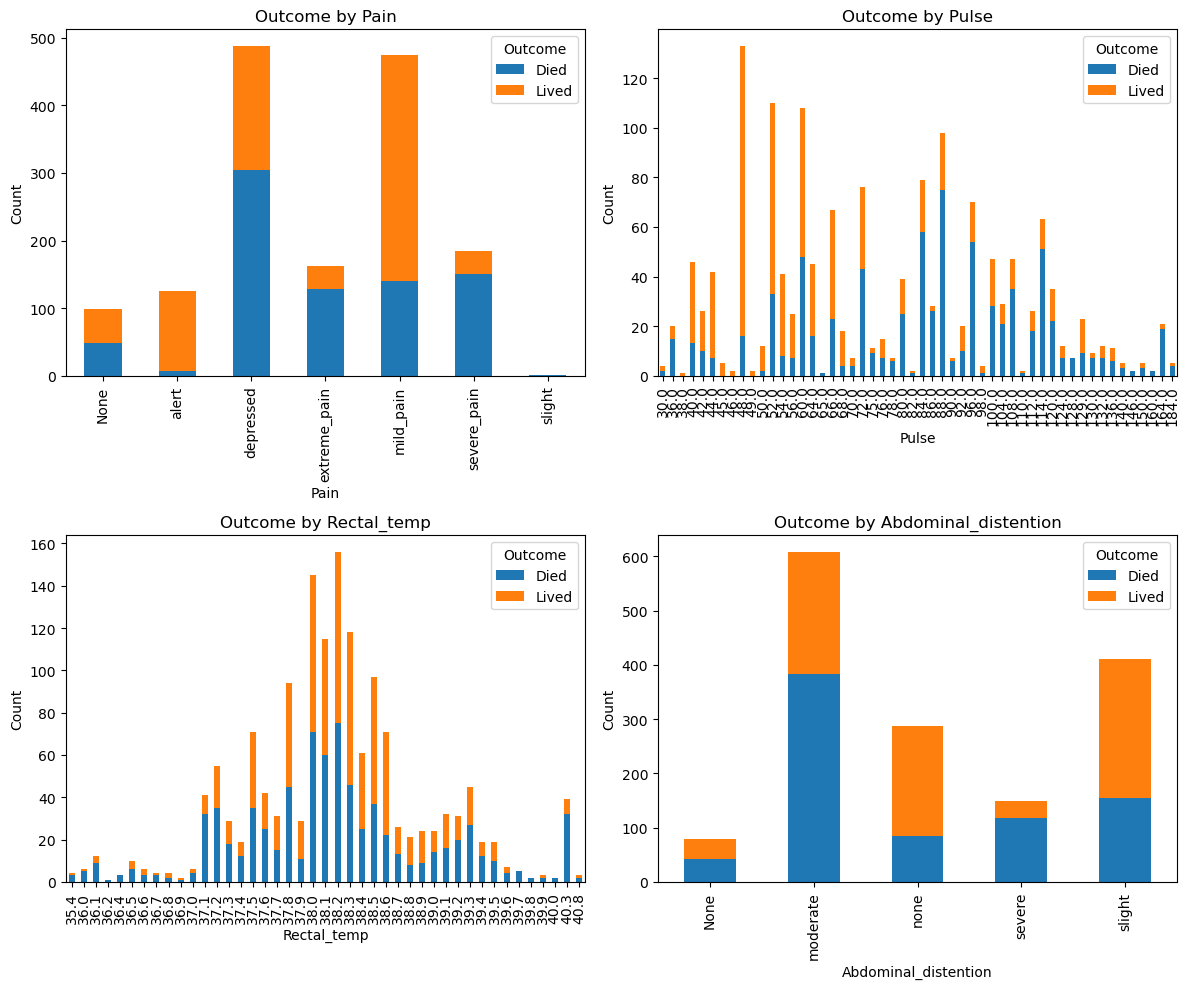

In [56]:
# Define the top 4 important features
top_features = horse_data[["pain", "pulse", "rectal_temp", "abdominal_distention"]]

# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

for i, feature in enumerate(top_features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Create a grouped bar plot for each feature
    horse_data.groupby([feature, "outcome"]).size().unstack().plot(kind="bar", stacked=True, ax=ax)
    
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Count")
    ax.set_title(f"Outcome by {feature.capitalize()}")
    ax.legend(title="Outcome", labels=["Died", "Lived"])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=nan total time=   0.0s

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 429, in fit
    X, y = self._validate_data(
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\sarah\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\sarah\anaconda3\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'yes'
